In [1]:
#import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans

In [2]:
#upload data
business_data = pd.read_csv("Resources/yelp_business.csv")
business_hours_data = pd.read_csv("Resources/yelp_business_hours.csv")
check_in_data = pd.read_csv("Resources/yelp_checkin.csv")
review_data  = pd.read_csv("Resources/yelp_review.csv")
business_attributes_data = pd.read_csv("Resources/yelp_business_attributes.csv")
tip_data = pd.read_csv("Resources/yelp_tip.csv")
user_data = pd.read_csv("Resources/yelp_user.csv")

In [3]:
name_df = business_data[['business_id', 'name']]

In [4]:
#dataframe of 5 businesses 
review_df = pd.merge(review_data, name_df, how = 'left', left_on = 'business_id', right_on = 'business_id')
review_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,"""Wilensky's"""
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,"""Tuck Shop"""
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,"""Lester's Deli"""
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,"""Five Guys"""
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,"""Maison Christian Faure"""


In [5]:
#null values
business_data.isnull().sum().sort_values(ascending = False)

neighborhood    106552
postal_code        623
longitude            1
latitude             1
state                1
city                 1
categories           0
is_open              0
review_count         0
stars                0
address              0
name                 0
business_id          0
dtype: int64

In [6]:
#number of restaurants in each city from business_data
business_data.city.value_counts()

Las Vegas                  26775
Phoenix                    17213
Toronto                    17206
Charlotte                   8553
Scottsdale                  8228
Pittsburgh                  6355
Mesa                        5760
Montréal                    5709
Henderson                   4465
Tempe                       4263
Chandler                    3994
Edinburgh                   3868
Cleveland                   3322
Madison                     3213
Glendale                    3206
Gilbert                     3128
Mississauga                 2726
Stuttgart                   2000
Peoria                      1706
Markham                     1564
North Las Vegas             1393
Champaign                   1195
Scarborough                 1095
North York                  1092
Surprise                    1018
Richmond Hill                888
Concord                      864
Brampton                     839
Goodyear                     772
Vaughan                      768
          

Text(0.5,1,'Top 20 Cities by Businesses Listed')

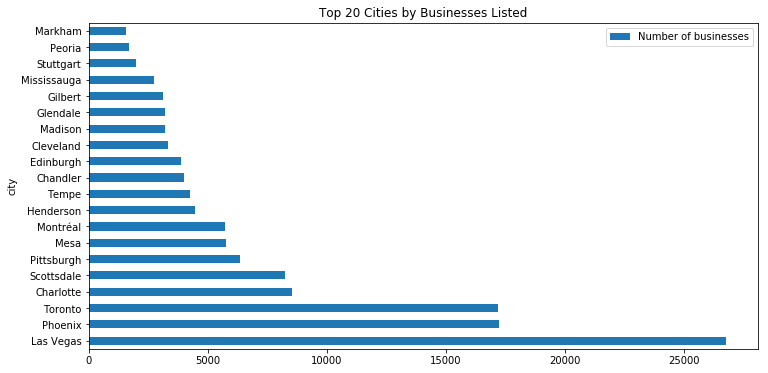

In [7]:
#bar graph for number of businesses in different cities 
city_business_counts = business_data[['city', 'business_id']].groupby(['city'])\
['business_id'].agg('count').sort_values(ascending=False)
city_business_counts = pd.DataFrame(data = city_business_counts)
city_business_counts.rename(columns={'business_id' : 'Number of businesses'}, inplace=True)

city_business_counts[0:20].sort_values(ascending=False, by="Number of businesses")\
.plot(kind='barh', stacked=False, figsize=[12,6])
plt.title('Top 20 Cities by Businesses Listed')

In [16]:
#table of cities with most reviews and average ratings
city_business_reviews = business_data[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

,review_count,stars
city,,
Las Vegas,1604173,3.709916
Phoenix,576709,3.673793
Toronto,430923,3.487272
Scottsdale,308529,3.948529
Charlotte,237115,3.571554
Pittsburgh,179471,3.629819
Henderson,166884,3.789362
Tempe,162772,3.729885
Mesa,130883,3.636024


In [18]:
stats.ttest_ind(city_business_reviews['review_count'], business_data['review_count'], equal_var = False)

Ttest_indResult(statistic=2.834935927335637, pvalue=0.004668011142103003)

In [19]:
stats.ttest_ind(city_business_reviews['stars'], business_data['stars'], equal_var = False)

Ttest_indResult(statistic=2.09312158301718, pvalue=0.0365626592797987)

Text(0.5,1,'Cities with greater than 100k reviews ranked by stars')

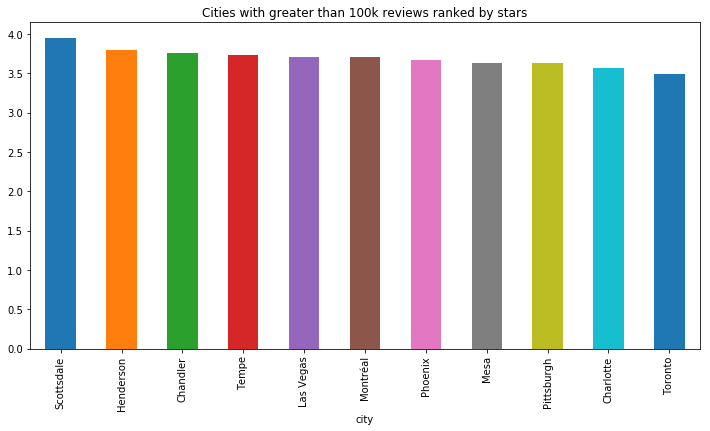

In [20]:
#bar graph of numbers of reviews for each city ranked by stars
city_business_reviews[city_business_reviews.review_count > 100000]['stars'].sort_values(ascending =False)\
.plot(kind='bar', stacked=False, figsize=[12,6])
plt.title('Cities with greater than 100k reviews ranked by stars')

There are  59106  different types/categories of Businesses in Yelp!


Text(0.5,0,'Category')

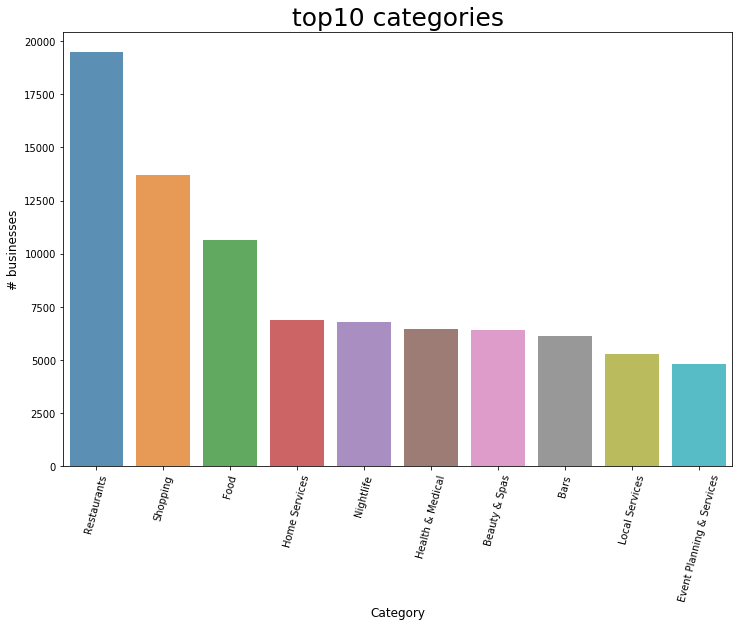

In [21]:
# bar graph of popular business categories
business_cats=' '.join(business_data['categories'])

cats=pd.DataFrame(business_cats.split(';'),columns=['category'])
x=cats.category.value_counts()
print("There are ",len(x)," different types/categories of Businesses in Yelp!")
#prep for chart
x=x.sort_values(ascending=False)
x=x.iloc[0:10]

plt.figure(figsize=(12,8))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("top10 categories",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=75)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

In [22]:
#top 10 most reviewed businesses
business_data[['name', 'business_id','review_count','city','stars']].sort_values(ascending = False,by='review_count')[0:10]

,name,business_id,review_count,city,stars
97944,"""Mon Ami Gabi""",4JNXUYY8wbaaDmk3BPzlWw,7361,Las Vegas,4.0
119907,"""Bacchanal Buffet""",RESDUcs7fIiihp38-d6_6g,7009,Las Vegas,4.0
69993,"""Wicked Spoon""",K7lWdNUhCbcnEvI0NhGewg,5950,Las Vegas,3.5
81212,"""Gordon Ramsay BurGR""",cYwJA2A6I12KNkm2rtXd5g,5447,Las Vegas,4.0
139699,"""Earl of Sandwich""",DkYS3arLOhA8si5uUEmHOw,4869,Las Vegas,4.5
19191,"""Hash House A Go Go""",f4x1YBxkLrZg652xt2KR5g,4774,Las Vegas,4.0
80590,"""The Buffet""",2weQS-RnoOBhb1KsHKyoSQ,4018,Las Vegas,3.5
124412,"""Lotus of Siam""",KskYqH1Bi7Z_61pH6Om8pg,3964,Las Vegas,4.0
21006,"""Serendipity 3""",eoHdUeQDNgQ6WYEnP2aiRw,3910,Las Vegas,3.0
93038,"""The Buffet at Bellagio""",ujHiaprwCQ5ewziu0Vi9rw,3838,Las Vegas,3.5


In [23]:
snowball = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [snowball.stem(word) for word in tokenizer.tokenize(text.lower())]

In [24]:
def vectorize_reviews(reviews):
    vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = tokenize, max_features = 1000)
    X = vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    return X, words

In [27]:
def print_clusters(company_id, K = 8, num_words = 10):
    company_df = review_df[review_df['business_id'] == company_id]
    company_name = company_df['name'].unique()[0]
    reviews = company_df['text'].values
    X, words = vectorize_reviews(reviews)
    
    kmeans = KMeans(n_clusters = K)
    kmeans.fit(X)
    
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-num_words-1:-1]
    print('Groups of ' + str(num_words) + ' words typically used together in reviews for ' + \
          company_name)
    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

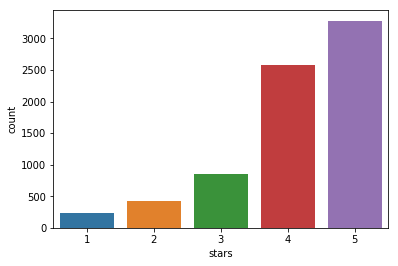

In [28]:
#number of reviews for each star rating for"Mon Ami Gabi" restaurant
bus_id = '4JNXUYY8wbaaDmk3BPzlWw'
company_df = review_df[review_df['business_id'] == bus_id]
sns.countplot(x = company_df['stars'])

In [29]:
#tips data
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 
                  'awful',  'disappoint','hate']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=selected_words, lowercase=False)
selected_word_count = vectorizer.fit_transform(tip_data['text'].values.astype('U'))
vectorizer.get_feature_names()

['awesome',
 'great',
 'fantastic',
 'amazing',
 'love',
 'horrible',
 'bad',
 'terrible',
 'awful',
 'disappoint',
 'hate']

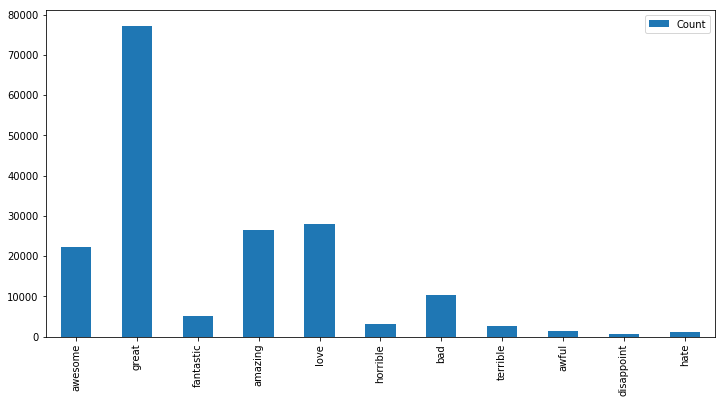

In [30]:
word_count_array = selected_word_count.toarray()
word_count_array.shape
word_count_array.sum(axis=0)
temp = pd.DataFrame(index=vectorizer.get_feature_names(), \
                    data=word_count_array.sum(axis=0)).rename(columns={0: 'Count'})
temp.plot(kind='bar', stacked=False, figsize=[12,6])

In [31]:
#one restaurant with high star rating and one with low star rating to see what the user tips look like
business_data[(business_data['city'] == 'Las Vegas') & (business_data['stars'] == 4.5)] 
business_data[(business_data['name'] == '"Lotus of Siam"')] #restaurant with many reviews

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
124412,KskYqH1Bi7Z_61pH6Om8pg,"""Lotus of Siam""",Downtown,"""953 E Sahara Ave, Ste A5""",Las Vegas,NV,89104,36.14345,-115.14278,4.0,3964,1,Car Dealers;Thai;Automotive;Seafood;Bars;Wine ...


In [32]:
Lotus_of_Siam = tip_data[tip_data.business_id==business_data.loc[173518,:].business_id]
Lotus_of_Siam_selected_word_count = \
vectorizer.fit_transform(Lotus_of_Siam['text'].values.astype('U'))
word_count_array = Lotus_of_Siam_selected_word_count.toarray()
temp = pd.DataFrame(index=vectorizer.get_feature_names(), \
                    data=word_count_array.sum(axis=0)).rename(columns={0: 'Count'})
temp

,Count
awesome,0
great,4
fantastic,0
amazing,2
love,2
horrible,0
bad,0
terrible,0
awful,0
disappoint,0


In [33]:
Lotus_of_Siam.head(10)

,text,date,likes,business_id,user_id
344616,FREE Thai Tea $20 or more for to go!,2016-08-30,0,LIU7IcJtD9VieoIo__wd9Q,pm7K54T6OmsDHREtiVBWGQ
432179,Great lunch special \nGreat service\nDelicious...,2016-12-22,0,LIU7IcJtD9VieoIo__wd9Q,iCXSs34zzuqM3gjd_Ok0ng
475315,CLOSED every MONDAY during summer 2016 - tempo...,2016-08-09,0,LIU7IcJtD9VieoIo__wd9Q,JQIZhoQB-Tg9hdBEj90m4g
475316,Small restaurant hiding behind McDonald's and ...,2016-08-09,0,LIU7IcJtD9VieoIo__wd9Q,JQIZhoQB-Tg9hdBEj90m4g
475317,Lunch specials only $6.95,2016-08-09,0,LIU7IcJtD9VieoIo__wd9Q,JQIZhoQB-Tg9hdBEj90m4g
504579,Minimum $15 purchase for debit and credit tran...,2017-03-03,0,LIU7IcJtD9VieoIo__wd9Q,3mRWq3C2ceY8CRJMfNLcHQ
537561,Very good drunkin noodle!!,2015-07-06,0,LIU7IcJtD9VieoIo__wd9Q,VgNPZASnWwdsx8cMb5Su4g
649085,Food is great! Love the curry puff and pad tha...,2016-03-08,0,LIU7IcJtD9VieoIo__wd9Q,VlWy5U6bSlvc5_Q4QdGDIw
690421,Check in for the thai tea & get their pad see ...,2017-08-15,0,LIU7IcJtD9VieoIo__wd9Q,SyX94Qkpowm_9dsn1SDrCQ
741448,This place really good papaya salad. One of th...,2017-07-29,0,LIU7IcJtD9VieoIo__wd9Q,_Fg79WQir7SFLSEtAREbXg
